# 가설 : 보증금 혹은 거래 금액은 상권 수에 영향을 받는다. 

In [82]:
import numpy as np
#import folium
import pandas as pd
#from folium import plugins
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
#from folium.plugins import MarkerCluster
import seaborn as sns
import json
import warnings

warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#예측 라이브러리
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso

from math import sqrt
import numpy as np
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [83]:
아파트  = pd.read_csv('./data/3.세종시_아파트(매매)_실거래가.csv', encoding='cp949' )
상권 = pd.read_csv('./data/14.세종시_상권정보.csv')
세대수 = pd.read_csv('./data/28.세종시_지역별_세대원수별_세대수.csv', encoding='cp949' )
가구소득 = pd.read_csv('./data/27.세종시_월평균_가구소득.csv', encoding='cp949' )
업종코드 = pd.read_csv('./data/15.세종시_상권정보_업종코드.csv')

In [84]:
def 전처리(부동산): # 파일명 3,4,6번 만 가능
    
    #상권대분류 전처리
    상권_대분류 = 상권.groupby(['행정동명','상권업종대분류코드']).count()
    상권_대분류 = 상권_대분류[['lon']]
    상권_대분류.rename(columns = {"lon":"count"},inplace=True)
    상권_대분류= 상권_대분류.reset_index()
    상권대분류_피벗 = pd.pivot_table(상권_대분류, index=['행정동명'], columns=['상권업종대분류코드'])
    상권대분류_피벗 = 상권대분류_피벗['count']
    상권대분류_피벗.columns.name = None 
    #아파트 전처리
    부동산 = 부동산[['시군구','전용면적(㎡)','거래금액(만원)','건축년도']]
    부동산['읍면동']= 부동산['시군구'].str.split(" ").str[1]
    #세대수 전처리
    세대수['읍면동'] = 세대수['읍면동'].str.replace(' ', "")
    try :
        del 세대수['계']
    except :
        pass
    #아프트_세대수 변수 생성
    부동산_세대수 = 부동산.merge(세대수, on='읍면동', how='left')
    부동산_세대수 = 부동산_세대수.merge(상권대분류_피벗, left_on = '읍면동',  right_on= '행정동명', how='left')
    del 부동산_세대수['읍면동']
    부동산_세대수 = 부동산_세대수.fillna(0)
    부동산_세대수['건축년도'] = 2021- 부동산_세대수['건축년도']
    
    return 부동산_세대수



def 라쏘(name,alpha,부동산):    
    try:
        부동산['거래금액(만원)'] = 부동산['거래금액(만원)'].str.replace(",","")
        부동산['거래금액(만원)'].astype('int64')
    
    except:
        pass
    
    x_num= 부동산[['전용면적(㎡)', '거래금액(만원)', '건축년도', '1인', '2인', '3인', '4인', '5인',
       '6인', '7인', '8인', '9인', '10인이상', 'D', 'F', 'L', 'N', 'O', 'P', 'Q',
       'R']]
    
    

    scaler = MinMaxScaler()
    scaler.fit(x_num)
    X_scaled = scaler.transform(x_num)
    X_scaled = pd.DataFrame(X_scaled, index=x_num.index, columns=x_num.columns)
    #X = pd.concat([X_scaled, x_cat], axis=1)
    y =X_scaled[['거래금액(만원)']]
    X= X_scaled.drop('거래금액(만원)',axis=1)
    
   

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    lasso = Lasso(alpha=alpha,random_state=42)
    lasso.fit(X_train, y_train)
    print("X_train,y_train Accuracy: {}%".format(round(lasso.score(X_train, y_train)*100, 2)))
    print("X_test,y_test Accuracy: {}%".format(round(lasso.score(X_test, y_test)*100, 2)))
    pred = lasso.predict(X_test)
    print(f"lasso alpha{alpha} y_test,pred Mse",mean_absolute_error(y_test, pred))
    print(f"lasso alpha{alpha} y_test,pred SQRT Mse",np.sqrt(mean_squared_error(y_test, pred)))
    plt.title(name)
    plt.grid(True)
    plt.scatter(x=y_test, y=pred)
    plt.plot([0, 0.7], [0, 0.7], 'r-')
    plt.figure(figsize=(7, 4))
    
    
    plt.show()
    plt.figure(figsize=(7, 6))
    plt.barh(X_train.columns, lasso.coef_)
    plt.grid(True)
    plt.show()



# 예측 모델(라쏘)

In [85]:
alphas = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]

X_train,y_train Accuracy: 0.0%
X_test,y_test Accuracy: -0.0%
lasso alpha100 y_test,pred Mse 0.09572128509676939
lasso alpha100 y_test,pred SQRT Mse 0.1264879427524569


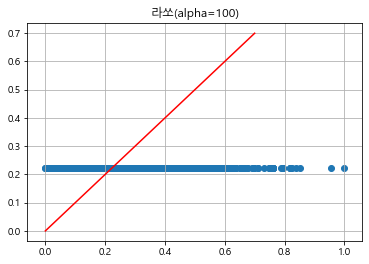

<Figure size 504x288 with 0 Axes>

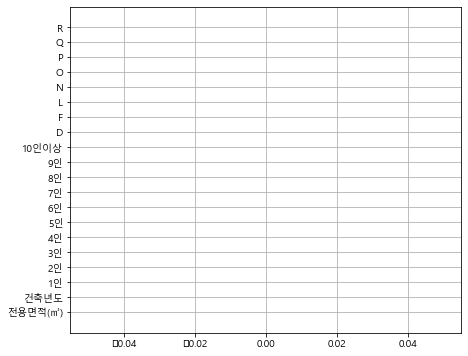

X_train,y_train Accuracy: 0.0%
X_test,y_test Accuracy: -0.0%
lasso alpha10 y_test,pred Mse 0.09572128509676939
lasso alpha10 y_test,pred SQRT Mse 0.1264879427524569


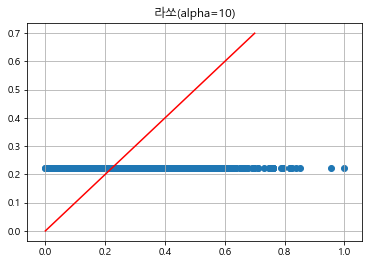

<Figure size 504x288 with 0 Axes>

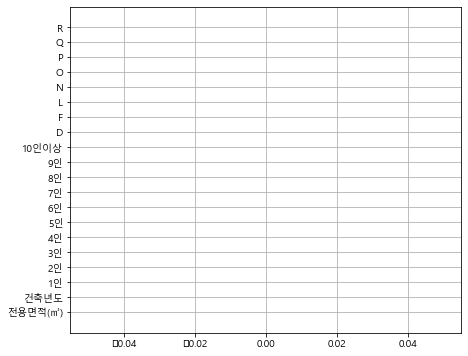

X_train,y_train Accuracy: 0.0%
X_test,y_test Accuracy: -0.0%
lasso alpha1 y_test,pred Mse 0.09572128509676939
lasso alpha1 y_test,pred SQRT Mse 0.1264879427524569


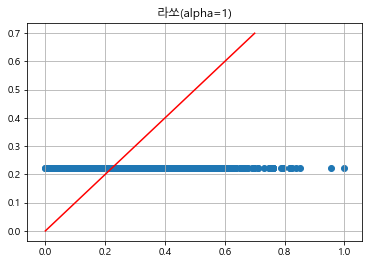

<Figure size 504x288 with 0 Axes>

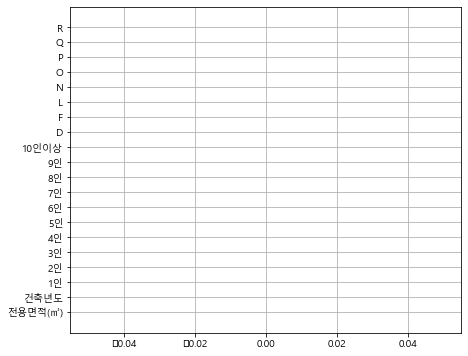

X_train,y_train Accuracy: 0.0%
X_test,y_test Accuracy: -0.0%
lasso alpha0.1 y_test,pred Mse 0.09572128509676939
lasso alpha0.1 y_test,pred SQRT Mse 0.1264879427524569


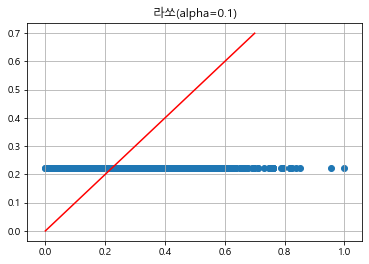

<Figure size 504x288 with 0 Axes>

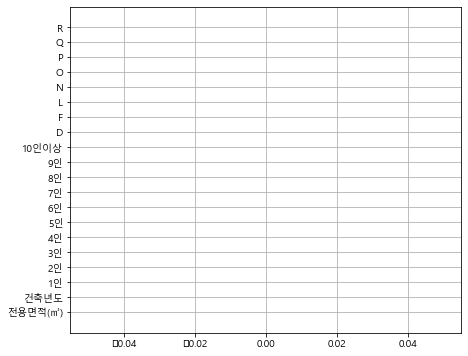

X_train,y_train Accuracy: 16.74%
X_test,y_test Accuracy: 16.44%
lasso alpha0.01 y_test,pred Mse 0.08505594750131704
lasso alpha0.01 y_test,pred SQRT Mse 0.11562278675739361


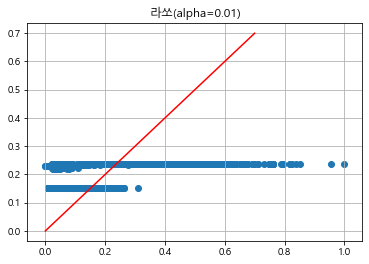

<Figure size 504x288 with 0 Axes>

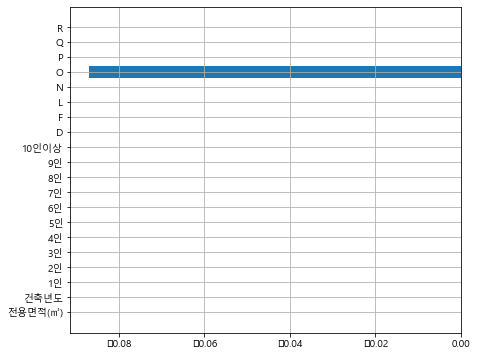

X_train,y_train Accuracy: 60.86%
X_test,y_test Accuracy: 60.11%
lasso alpha0.001 y_test,pred Mse 0.059497946129468814
lasso alpha0.001 y_test,pred SQRT Mse 0.07988539857730388


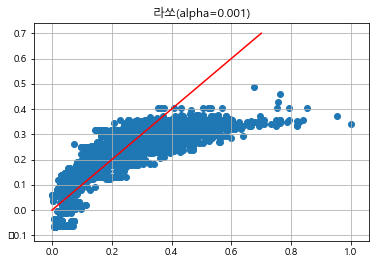

<Figure size 504x288 with 0 Axes>

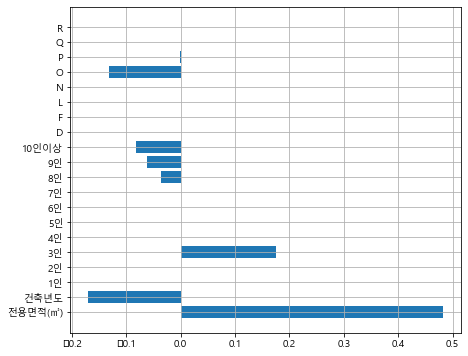

X_train,y_train Accuracy: 68.07%
X_test,y_test Accuracy: 67.28%
lasso alpha0.0001 y_test,pred Mse 0.05320781788832087
lasso alpha0.0001 y_test,pred SQRT Mse 0.072349839772159


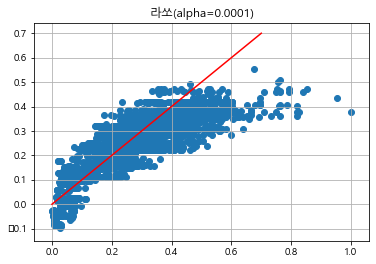

<Figure size 504x288 with 0 Axes>

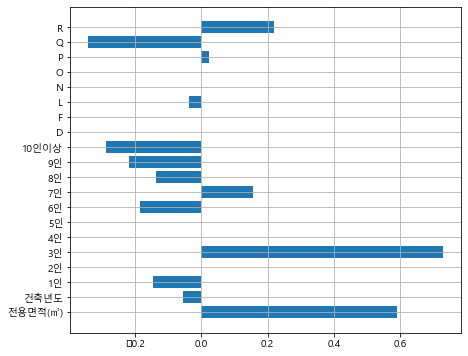

In [86]:

for alpha in alphas :
    연립다세대 = pd.read_csv('./data/3.세종시_아파트(매매)_실거래가.csv', encoding='cp949') #빌라

    라쏘("라쏘(alpha={})".format(alpha),alpha,전처리(연립다세대))



X_train,y_train Accuracy: 0.0%
X_test,y_test Accuracy: -0.53%
lasso alpha100 y_test,pred Mse 0.1180941021884418
lasso alpha100 y_test,pred SQRT Mse 0.1500235173942786


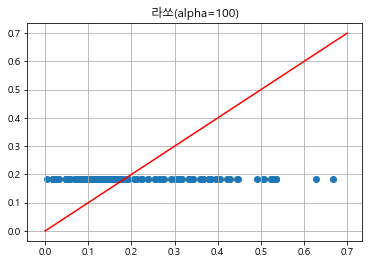

<Figure size 504x288 with 0 Axes>

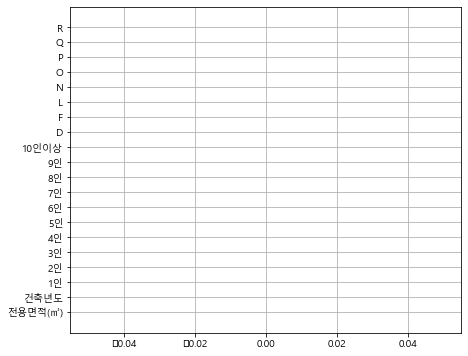

X_train,y_train Accuracy: 0.0%
X_test,y_test Accuracy: -0.53%
lasso alpha10 y_test,pred Mse 0.1180941021884418
lasso alpha10 y_test,pred SQRT Mse 0.1500235173942786


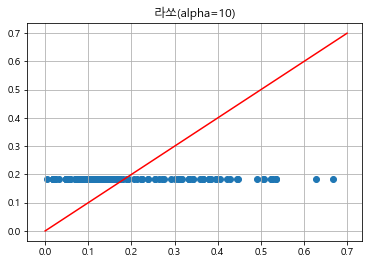

<Figure size 504x288 with 0 Axes>

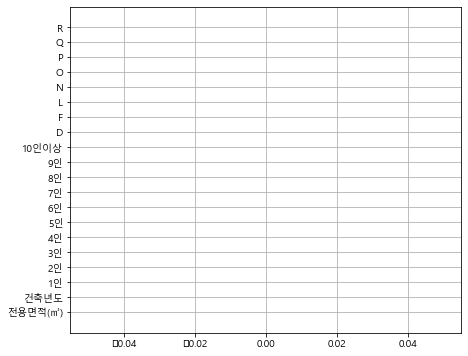

X_train,y_train Accuracy: 0.0%
X_test,y_test Accuracy: -0.53%
lasso alpha1 y_test,pred Mse 0.1180941021884418
lasso alpha1 y_test,pred SQRT Mse 0.1500235173942786


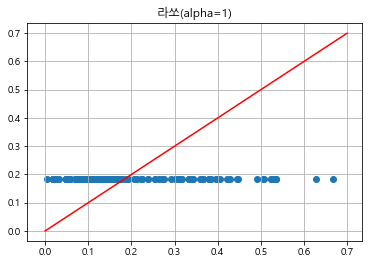

<Figure size 504x288 with 0 Axes>

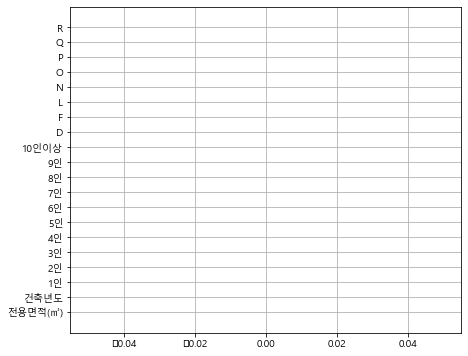

X_train,y_train Accuracy: 0.0%
X_test,y_test Accuracy: -0.53%
lasso alpha0.1 y_test,pred Mse 0.1180941021884418
lasso alpha0.1 y_test,pred SQRT Mse 0.1500235173942786


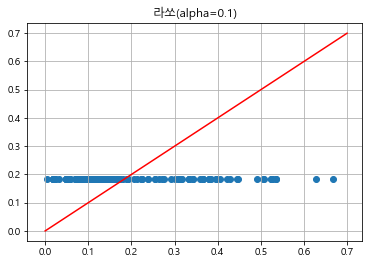

<Figure size 504x288 with 0 Axes>

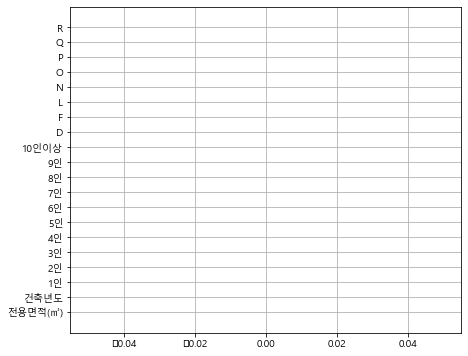

X_train,y_train Accuracy: 26.63%
X_test,y_test Accuracy: 29.42%
lasso alpha0.01 y_test,pred Mse 0.09676537308731316
lasso alpha0.01 y_test,pred SQRT Mse 0.12570769202311136


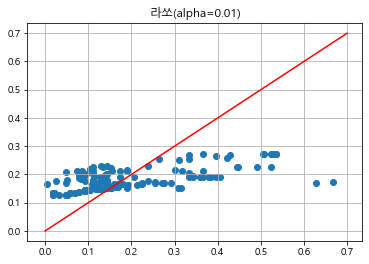

<Figure size 504x288 with 0 Axes>

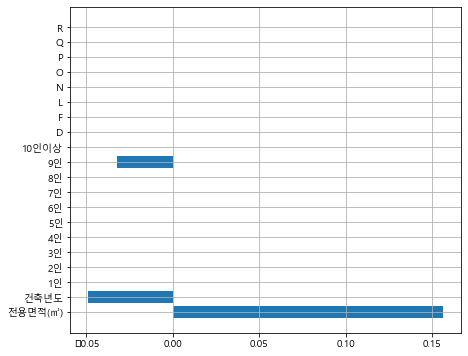

X_train,y_train Accuracy: 54.63%
X_test,y_test Accuracy: 56.24%
lasso alpha0.001 y_test,pred Mse 0.06763123582615367
lasso alpha0.001 y_test,pred SQRT Mse 0.0989741637958161


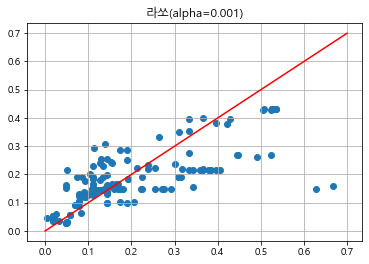

<Figure size 504x288 with 0 Axes>

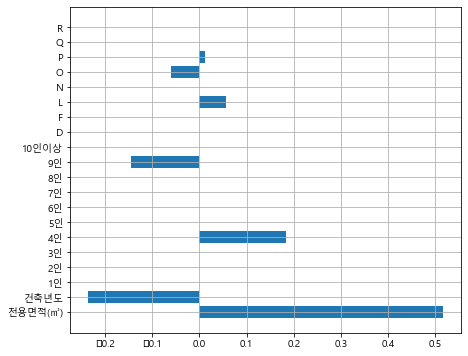

X_train,y_train Accuracy: 59.69%
X_test,y_test Accuracy: 61.83%
lasso alpha0.0001 y_test,pred Mse 0.06168412025048058
lasso alpha0.0001 y_test,pred SQRT Mse 0.09244248885961366


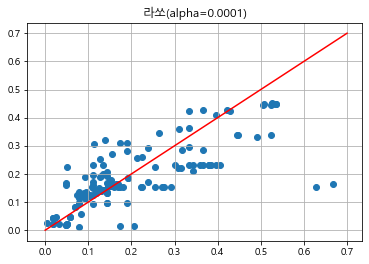

<Figure size 504x288 with 0 Axes>

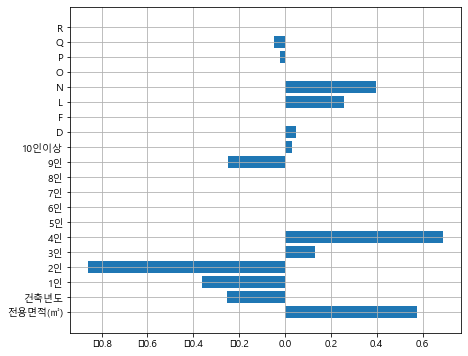

In [87]:
for alpha in alphas :
    연립다세대 = pd.read_csv('./data/4.세종시_연립다세대(매매)_실거래가.csv', encoding='cp949') #빌라

    라쏘("라쏘(alpha={})".format(alpha),alpha,전처리(연립다세대))

X_train,y_train Accuracy: 0.0%
X_test,y_test Accuracy: -0.71%
lasso alpha100 y_test,pred Mse 0.11104375738452815
lasso alpha100 y_test,pred SQRT Mse 0.14363240594004353


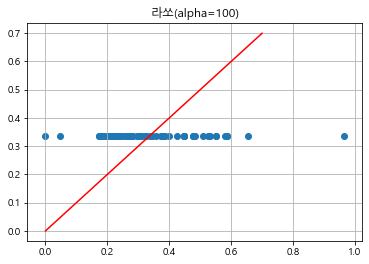

<Figure size 504x288 with 0 Axes>

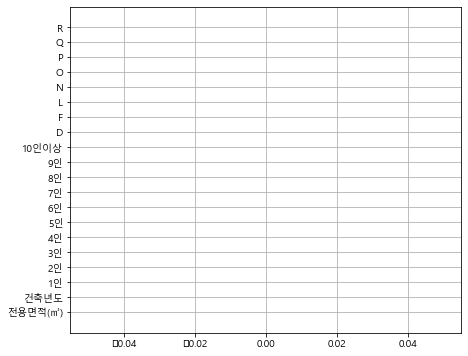

X_train,y_train Accuracy: 0.0%
X_test,y_test Accuracy: -0.71%
lasso alpha10 y_test,pred Mse 0.11104375738452815
lasso alpha10 y_test,pred SQRT Mse 0.14363240594004353


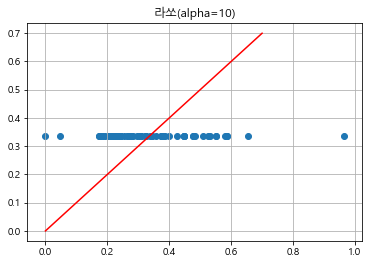

<Figure size 504x288 with 0 Axes>

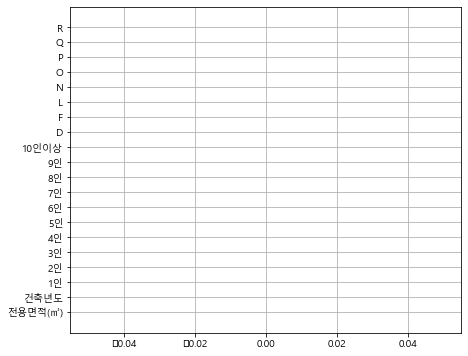

X_train,y_train Accuracy: 0.0%
X_test,y_test Accuracy: -0.71%
lasso alpha1 y_test,pred Mse 0.11104375738452815
lasso alpha1 y_test,pred SQRT Mse 0.14363240594004353


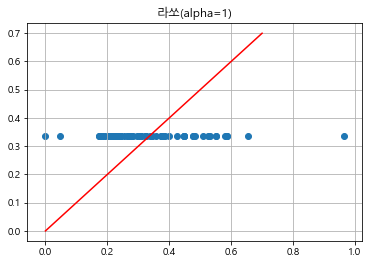

<Figure size 504x288 with 0 Axes>

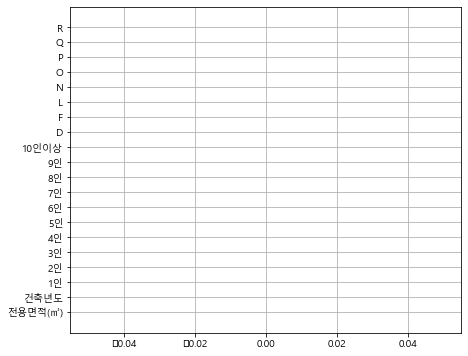

X_train,y_train Accuracy: 0.0%
X_test,y_test Accuracy: -0.71%
lasso alpha0.1 y_test,pred Mse 0.11104375738452815
lasso alpha0.1 y_test,pred SQRT Mse 0.14363240594004353


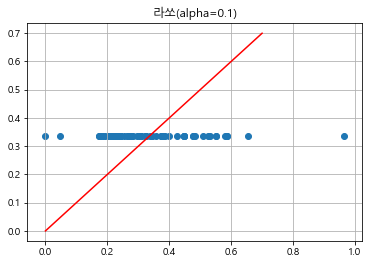

<Figure size 504x288 with 0 Axes>

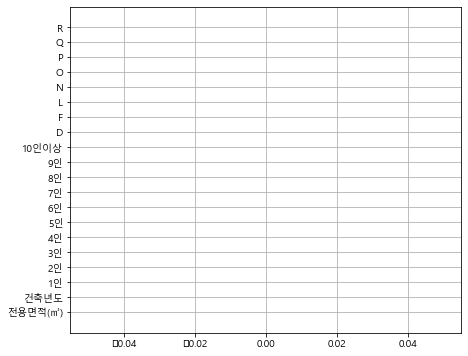

X_train,y_train Accuracy: 21.84%
X_test,y_test Accuracy: 15.82%
lasso alpha0.01 y_test,pred Mse 0.09969361866330557
lasso alpha0.01 y_test,pred SQRT Mse 0.13131511546022082


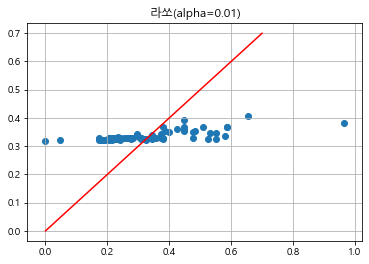

<Figure size 504x288 with 0 Axes>

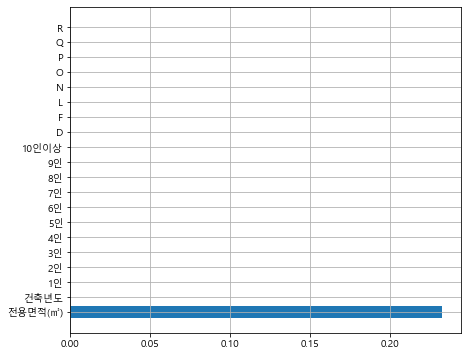

X_train,y_train Accuracy: 68.68%
X_test,y_test Accuracy: 51.77%
lasso alpha0.001 y_test,pred Mse 0.07262588594932184
lasso alpha0.001 y_test,pred SQRT Mse 0.09938986599572813


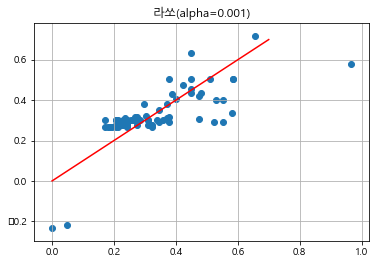

<Figure size 504x288 with 0 Axes>

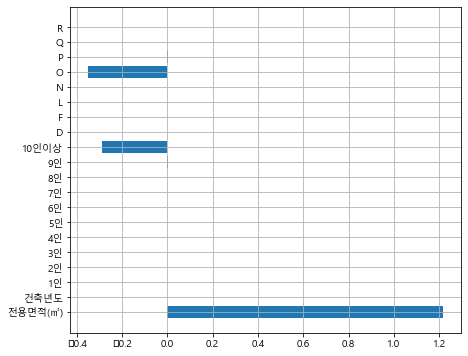

X_train,y_train Accuracy: 72.76%
X_test,y_test Accuracy: 35.18%
lasso alpha0.0001 y_test,pred Mse 0.0781696836164284
lasso alpha0.0001 y_test,pred SQRT Mse 0.11522421460028907


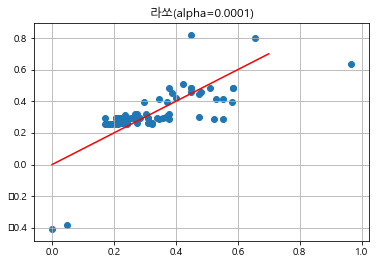

<Figure size 504x288 with 0 Axes>

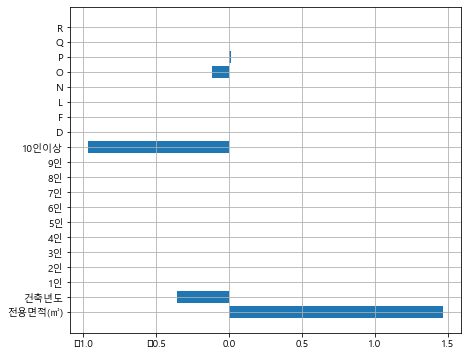

In [88]:
for alpha in alphas :
    연립다세대 = pd.read_csv('./data/6.세종시_오피스텔(매매)_실거래가.csv', encoding='cp949') #빌라

    라쏘("라쏘(alpha={})".format(alpha),alpha,전처리(연립다세대))

In [89]:
def 전처리2(부동산): # 파일 5번만
    
    #상권대분류 전처리
    상권_대분류 = 상권.groupby(['행정동명','상권업종대분류코드']).count()
    상권_대분류 = 상권_대분류[['lon']]
    상권_대분류.rename(columns = {"lon":"count"},inplace=True)
    상권_대분류= 상권_대분류.reset_index()
    상권대분류_피벗 = pd.pivot_table(상권_대분류, index=['행정동명'], columns=['상권업종대분류코드'])
    상권대분류_피벗 = 상권대분류_피벗['count']
    상권대분류_피벗.columns.name = None 
    #아파트 전처리
    부동산 = 부동산[['시군구','대지면적(㎡)','연면적(㎡)','도로조건','주택유형','거래금액(만원)','건축년도']]
    부동산['읍면동']= 부동산['시군구'].str.split(" ").str[1]
    #세대수 전처리
    세대수['읍면동'] = 세대수['읍면동'].str.replace(' ', "")
    try :
        del 세대수['계']
    except :
        pass
    #아프트_세대수 변수 생성
    부동산_세대수 = 부동산.merge(세대수, on='읍면동', how='left')
    부동산_세대수 = 부동산_세대수.merge(상권대분류_피벗, left_on = '읍면동',  right_on= '행정동명', how='left')
    del 부동산_세대수['읍면동']
    부동산_세대수 = 부동산_세대수.fillna(0)
    부동산_세대수['건축년도'] = 2021- 부동산_세대수['건축년도']
    부동산_세대수 = pd.get_dummies(부동산_세대수, columns=['주택유형','도로조건'])
    
    return 부동산_세대수

def 라쏘2(name,alpha,부동산):    
    try:
        부동산['거래금액(만원)'] = 부동산['거래금액(만원)'].str.replace(",","")
        부동산['거래금액(만원)'].astype('int64')
    
    except:
        pass
    
    x_num= 부동산[['대지면적(㎡)', '연면적(㎡)', '거래금액(만원)', '건축년도', '1인', '2인', '3인', '4인',
       '5인', '6인', '7인', '8인', '9인', '10인이상', 'D', 'F', 'L', 'N', 'O', 'P',
       'Q', 'R', '주택유형_다가구', '주택유형_단독', '도로조건_-', '도로조건_12m미만', '도로조건_25m미만',
       '도로조건_25m이상', '도로조건_8m미만']]
    
    

    scaler = MinMaxScaler()
    scaler.fit(x_num)
    X_scaled = scaler.transform(x_num)
    X_scaled = pd.DataFrame(X_scaled, index=x_num.index, columns=x_num.columns)
    #X = pd.concat([X_scaled, x_cat], axis=1)
    y =X_scaled[['거래금액(만원)']]
    X= X_scaled.drop('거래금액(만원)',axis=1)
   

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    lasso = Lasso(alpha=alpha,random_state=42)
    lasso.fit(X_train, y_train)
    print("X_train,y_train Accuracy: {}%".format(round(lasso.score(X_train, y_train)*100, 2)))
    print("X_test,y_test Accuracy: {}%".format(round(lasso.score(X_test, y_test)*100, 2)))
    pred = lasso.predict(X_test)
    print(f"lasso alpha{alpha} y_test,pred Mse",mean_absolute_error(y_test, pred))
    print(f"lasso alpha{alpha} y_test,pred SQRT Mse",np.sqrt(mean_squared_error(y_test, pred)))
    
    plt.title(name)
    plt.grid(True)
    plt.scatter(x=y_test, y=pred)
    plt.plot([0, 0.7], [0, 0.7], 'r-')
    plt.figure(figsize=(7, 4))
    
    
    plt.show()
    plt.figure(figsize=(7, 6))
    plt.barh(X_train.columns, lasso.coef_)
    plt.grid(True)
    plt.show()



In [90]:
단독다가구.columns

Index(['계약년월', '계약일', '시군구', '본번', '부번', '단지명', '전월세구분', '전용면적(㎡)', '보증금(만원)',
       '월세(만원)', '층', '건축년도'],
      dtype='object')

X_train,y_train Accuracy: 0.0%
X_test,y_test Accuracy: -0.1%
lasso alpha100 y_test,pred Mse 0.07314191950940127
lasso alpha100 y_test,pred SQRT Mse 0.10569141888909835


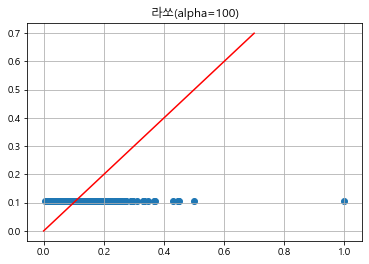

<Figure size 504x288 with 0 Axes>

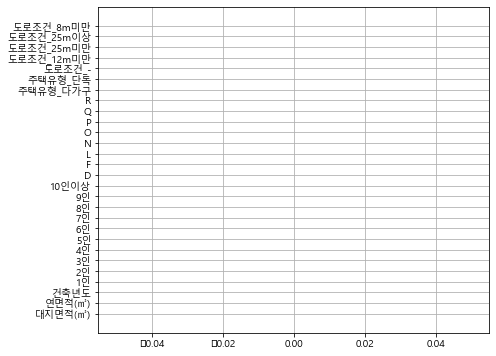

X_train,y_train Accuracy: 0.0%
X_test,y_test Accuracy: -0.1%
lasso alpha10 y_test,pred Mse 0.07314191950940127
lasso alpha10 y_test,pred SQRT Mse 0.10569141888909835


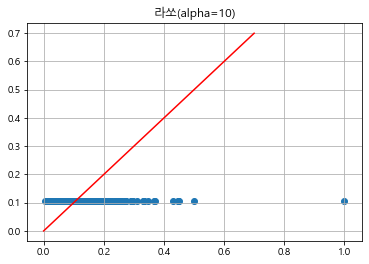

<Figure size 504x288 with 0 Axes>

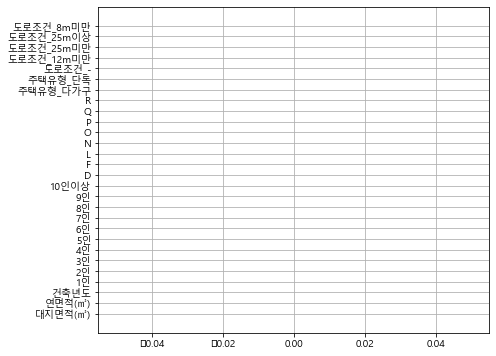

X_train,y_train Accuracy: 0.0%
X_test,y_test Accuracy: -0.1%
lasso alpha1 y_test,pred Mse 0.07314191950940127
lasso alpha1 y_test,pred SQRT Mse 0.10569141888909835


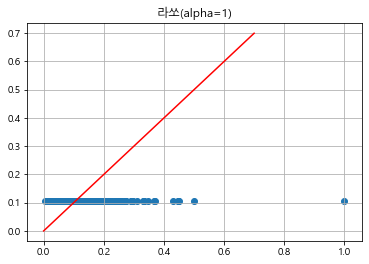

<Figure size 504x288 with 0 Axes>

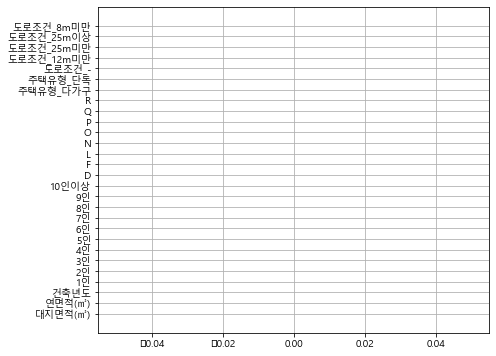

X_train,y_train Accuracy: 0.0%
X_test,y_test Accuracy: -0.1%
lasso alpha0.1 y_test,pred Mse 0.07314191950940127
lasso alpha0.1 y_test,pred SQRT Mse 0.10569141888909835


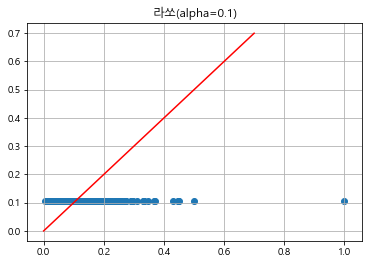

<Figure size 504x288 with 0 Axes>

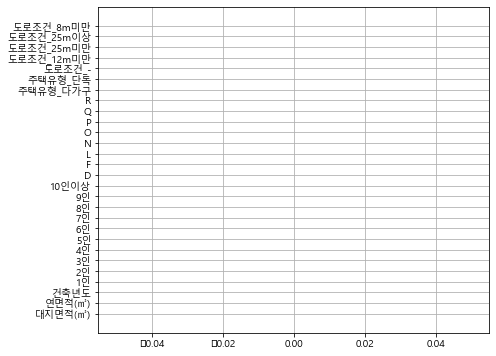

X_train,y_train Accuracy: 10.47%
X_test,y_test Accuracy: 6.27%
lasso alpha0.01 y_test,pred Mse 0.0695407800600082
lasso alpha0.01 y_test,pred SQRT Mse 0.10227476511435783


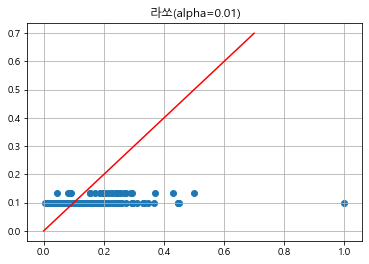

<Figure size 504x288 with 0 Axes>

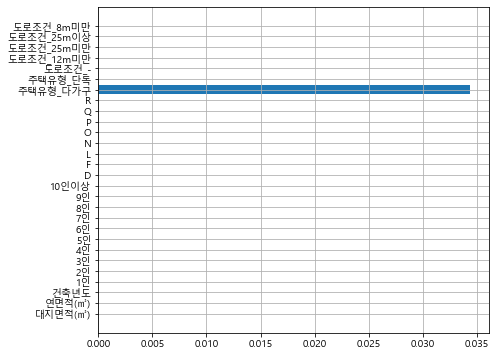

X_train,y_train Accuracy: 65.16%
X_test,y_test Accuracy: 61.31%
lasso alpha0.001 y_test,pred Mse 0.04049445360593398
lasso alpha0.001 y_test,pred SQRT Mse 0.06570674399216708


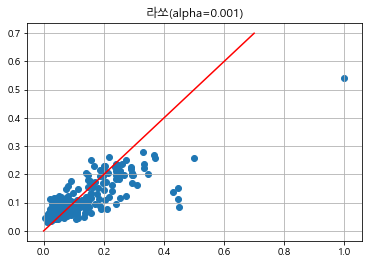

<Figure size 504x288 with 0 Axes>

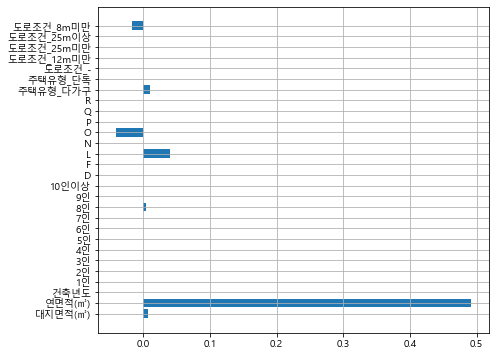

X_train,y_train Accuracy: 70.89%
X_test,y_test Accuracy: 68.09%
lasso alpha0.0001 y_test,pred Mse 0.03538079228983029
lasso alpha0.0001 y_test,pred SQRT Mse 0.05967502891046154


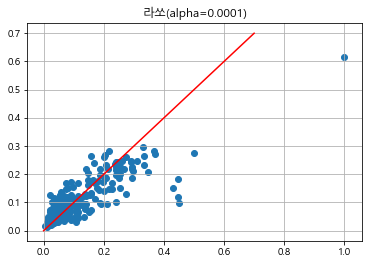

<Figure size 504x288 with 0 Axes>

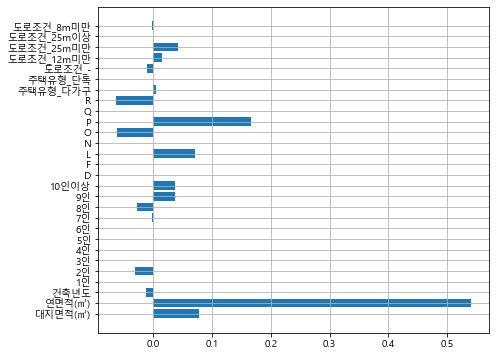

In [91]:
for alpha in alphas :
    단독다가구 = pd.read_csv('./data/5.세종시_단독다가구(매매)_실거래가.csv', encoding='cp949')

    라쏘2("라쏘(alpha={})".format(alpha),alpha,전처리2(단독다가구))



In [92]:
def 전처리3(부동산): 
    
    #상권대분류 전처리
    상권_대분류 = 상권.groupby(['행정동명','상권업종대분류코드']).count()
    상권_대분류 = 상권_대분류[['lon']]
    상권_대분류.rename(columns = {"lon":"count"},inplace=True)
    상권_대분류= 상권_대분류.reset_index()
    상권대분류_피벗 = pd.pivot_table(상권_대분류, index=['행정동명'], columns=['상권업종대분류코드'])
    상권대분류_피벗 = 상권대분류_피벗['count']
    상권대분류_피벗.columns.name = None 
    #아파트 전처리
    부동산 = 부동산[['시군구','전용면적(㎡)','전월세구분','보증금(만원)','월세(만원)','층','건축년도']]
    부동산['읍면동']= 부동산['시군구'].str.split(" ").str[1]
    #세대수 전처리
    세대수['읍면동'] = 세대수['읍면동'].str.replace(' ', "")
    try :
        del 세대수['계']
    except :
        pass
    #아프트_세대수 변수 생성
    부동산_세대수 = 부동산.merge(세대수, on='읍면동', how='left')
    부동산_세대수 = 부동산_세대수.merge(상권대분류_피벗, left_on = '읍면동',  right_on= '행정동명', how='left')
    del 부동산_세대수['읍면동']
    부동산_세대수 = 부동산_세대수.fillna(0)
    부동산_세대수['건축년도'] = 2021- 부동산_세대수['건축년도']
    부동산_세대수 = pd.get_dummies(부동산_세대수, columns=['전월세구분','층'])
    
    return 부동산_세대수


In [93]:
def 라쏘3(name,alpha,부동산):    
    try:
        부동산['거래금액(만원)'] = 부동산['거래금액(만원)'].str.replace(",","")
        부동산['거래금액(만원)'].astype('int64')
    
    except:
        pass
    
    x_num= 부동산[['전용면적(㎡)', '보증금(만원)', '월세(만원)', '건축년도', '1인', '2인', '3인', '4인',
       '5인', '6인', '7인', '8인', '9인', '10인이상', 'D', 'F', 'L', 'N', 'O', 'P',
       'Q', 'R', '전월세구분_월세', '전월세구분_전세', '층_-1', '층_1', '층_2', '층_3', '층_4',
       '층_5', '층_6', '층_7', '층_8', '층_9', '층_10', '층_11', '층_12', '층_13',
       '층_14', '층_15', '층_16', '층_17', '층_18', '층_19', '층_20', '층_21', '층_22',
       '층_23', '층_24', '층_25', '층_26', '층_27', '층_28', '층_29', '층_30', '층_31',
       '층_32', '층_33']]
    
    

    scaler = MinMaxScaler()
    scaler.fit(x_num)
    X_scaled = scaler.transform(x_num)
    X_scaled = pd.DataFrame(X_scaled, index=x_num.index, columns=x_num.columns)
    #X = pd.concat([X_scaled, x_cat], axis=1)
    y =X_scaled[['보증금(만원)']]
    X= X_scaled.drop('보증금(만원)',axis=1)
   

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    lasso = Lasso(alpha=alpha,random_state=42)
    lasso.fit(X_train, y_train)
    print("X_train,y_train Accuracy: {}%".format(round(lasso.score(X_train, y_train)*100, 2)))
    print("X_test,y_test Accuracy: {}%".format(round(lasso.score(X_test, y_test)*100, 2)))
    pred = lasso.predict(X_test)
    print(f"lasso alpha{alpha} y_test,pred Mse",mean_absolute_error(y_test, pred))
    print(f"lasso alpha{alpha} y_test,pred SQRT Mse",np.sqrt(mean_squared_error(y_test, pred)))
    plt.title(name)
    plt.grid(True)
    plt.scatter(x=y_test, y=pred)
    plt.plot([0, 0.7], [0, 0.7], 'r-')
    plt.figure(figsize=(7, 4))
    
    
    plt.show()
    plt.figure(figsize=(7, 6))
    plt.barh(X_train.columns, lasso.coef_)
    plt.grid(True)
    plt.show()



X_train,y_train Accuracy: 0.0%
X_test,y_test Accuracy: -0.0%
lasso alpha100 y_test,pred Mse 0.10060033639781445
lasso alpha100 y_test,pred SQRT Mse 0.12210554337618496


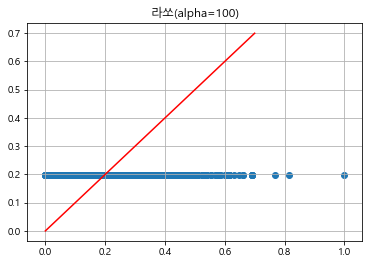

<Figure size 504x288 with 0 Axes>

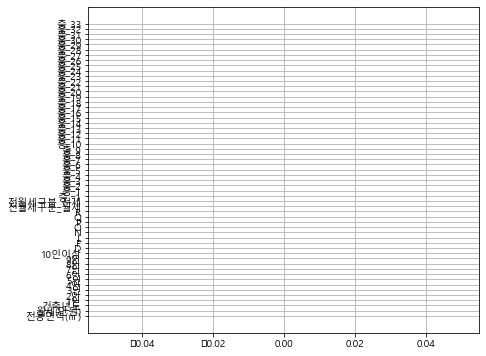

X_train,y_train Accuracy: 0.0%
X_test,y_test Accuracy: -0.0%
lasso alpha10 y_test,pred Mse 0.10060033639781445
lasso alpha10 y_test,pred SQRT Mse 0.12210554337618496


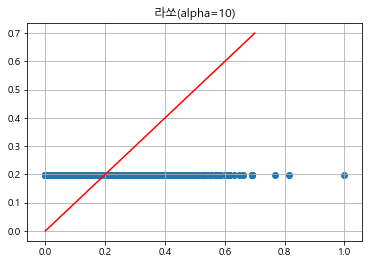

<Figure size 504x288 with 0 Axes>

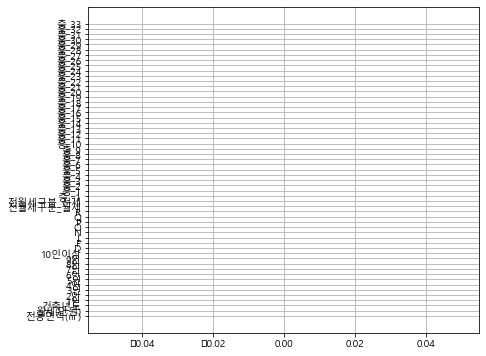

X_train,y_train Accuracy: 0.0%
X_test,y_test Accuracy: -0.0%
lasso alpha1 y_test,pred Mse 0.10060033639781445
lasso alpha1 y_test,pred SQRT Mse 0.12210554337618496


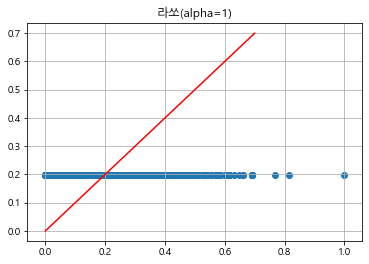

<Figure size 504x288 with 0 Axes>

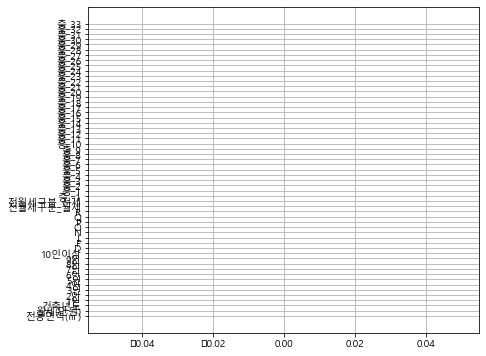

X_train,y_train Accuracy: 0.0%
X_test,y_test Accuracy: -0.0%
lasso alpha0.1 y_test,pred Mse 0.10060033639781445
lasso alpha0.1 y_test,pred SQRT Mse 0.12210554337618496


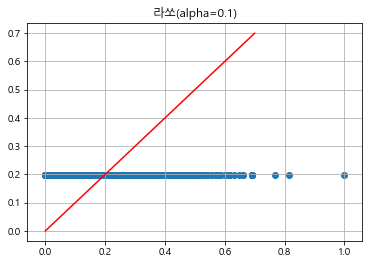

<Figure size 504x288 with 0 Axes>

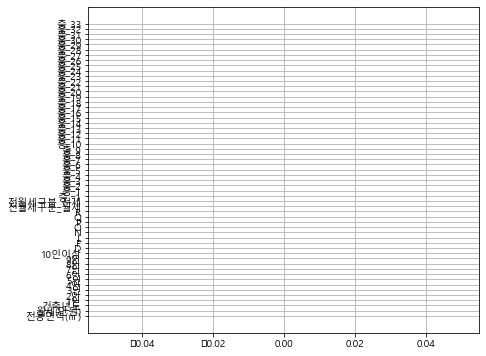

X_train,y_train Accuracy: 55.91%
X_test,y_test Accuracy: 55.98%
lasso alpha0.01 y_test,pred Mse 0.06294610956411777
lasso alpha0.01 y_test,pred SQRT Mse 0.08101062366975681


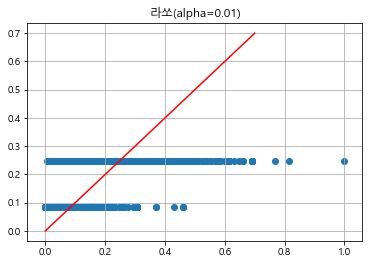

<Figure size 504x288 with 0 Axes>

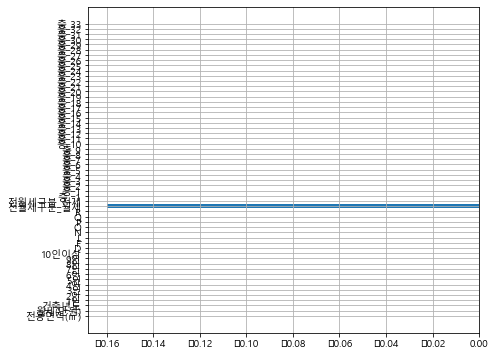

X_train,y_train Accuracy: 70.34%
X_test,y_test Accuracy: 69.94%
lasso alpha0.001 y_test,pred Mse 0.0510622556462008
lasso alpha0.001 y_test,pred SQRT Mse 0.06694635708515383


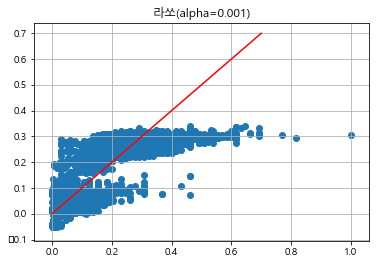

<Figure size 504x288 with 0 Axes>

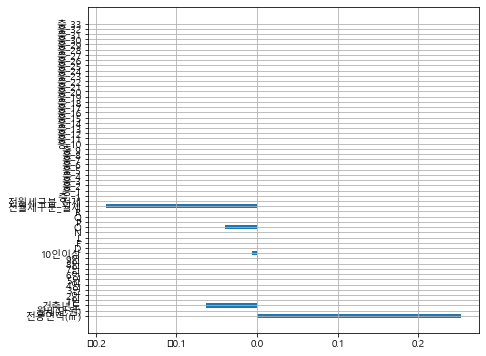

X_train,y_train Accuracy: 74.46%
X_test,y_test Accuracy: 74.19%
lasso alpha0.0001 y_test,pred Mse 0.04668599586679587
lasso alpha0.0001 y_test,pred SQRT Mse 0.062035577692450744


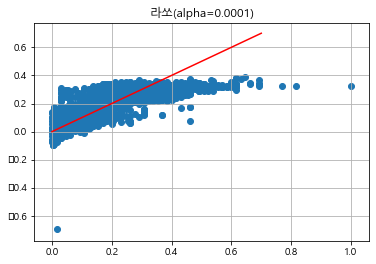

<Figure size 504x288 with 0 Axes>

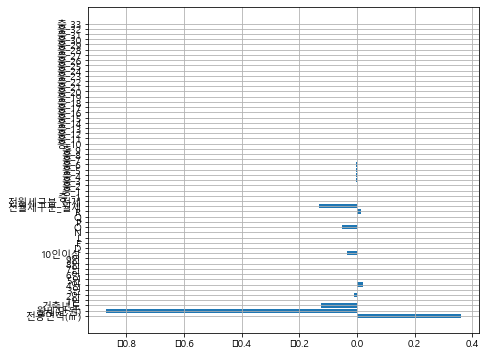

In [94]:
for alpha in alphas :
    단독다가구 = pd.read_csv('./data/7.세종시_아파트(전월세)_실거래가.csv', encoding='cp949')
    라쏘3("라쏘(alpha={})".format(alpha),alpha,전처리3(단독다가구))


In [95]:
def 라쏘4(name,alpha,부동산):  
    plt.grid(True)
    try:
        부동산['거래금액(만원)'] = 부동산['거래금액(만원)'].str.replace(",","")
        부동산['거래금액(만원)'].astype('int64')
    
    except:
        pass
    
    x_num= 부동산[['전용면적(㎡)', '보증금(만원)', '월세(만원)', '건축년도', '1인', '2인', '3인', '4인',
       '5인', '6인', '7인', '8인', '9인', '10인이상', 'D', 'F', 'L', 'N', 'O', 'P',
       'Q', 'R', '전월세구분_월세', '전월세구분_전세', '층_-1', '층_1', '층_2', '층_3', '층_4',
       '층_5', '층_6', '층_7', '층_8']]
    
    

    scaler = MinMaxScaler()
    scaler.fit(x_num)
    X_scaled = scaler.transform(x_num)
    X_scaled = pd.DataFrame(X_scaled, index=x_num.index, columns=x_num.columns)
    #X = pd.concat([X_scaled, x_cat], axis=1)
    y =X_scaled[['보증금(만원)']]
    X= X_scaled.drop('보증금(만원)',axis=1)
   

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    lasso = Lasso(alpha=alpha,random_state=42)
    lasso.fit(X_train, y_train)
    print("X_train,y_train Accuracy: {}%".format(round(lasso.score(X_train, y_train)*100, 2)))
    print("X_test,y_test Accuracy: {}%".format(round(lasso.score(X_test, y_test)*100, 2)))
    pred = lasso.predict(X_test)
    print(f"lasso alpha{alpha} y_test,pred Mse",mean_absolute_error(y_test, pred))
    print(f"lasso alpha{alpha} y_test,pred SQRT Mse",np.sqrt(mean_squared_error(y_test, pred)))
    plt.title(name)
    plt.grid(True)
    plt.scatter(x=y_test, y=pred)
    plt.plot([0, 0.7], [0, 0.7], 'r-')
    plt.figure(figsize=(7, 4))
    
    
    plt.show()
    plt.figure(figsize=(7, 6))
    plt.barh(X_train.columns, lasso.coef_)
    plt.grid(True)
    plt.show()



X_train,y_train Accuracy: 0.0%
X_test,y_test Accuracy: -8.23%
lasso alpha100 y_test,pred Mse 0.15467732974033035
lasso alpha100 y_test,pred SQRT Mse 0.18238013598215969


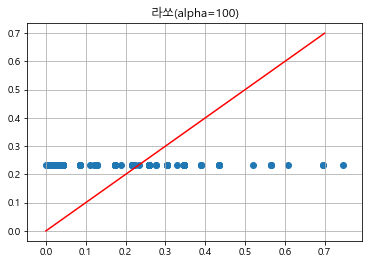

<Figure size 504x288 with 0 Axes>

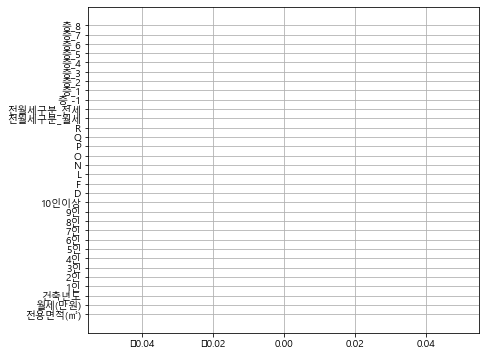

X_train,y_train Accuracy: 0.0%
X_test,y_test Accuracy: -8.23%
lasso alpha10 y_test,pred Mse 0.15467732974033035
lasso alpha10 y_test,pred SQRT Mse 0.18238013598215969


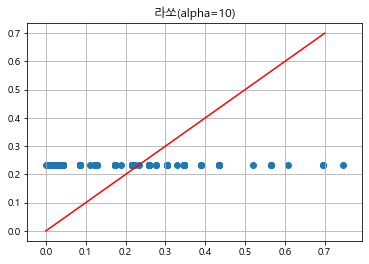

<Figure size 504x288 with 0 Axes>

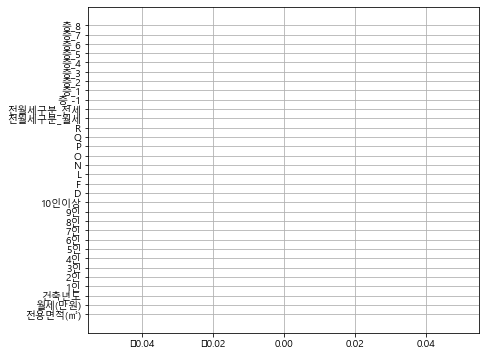

X_train,y_train Accuracy: 0.0%
X_test,y_test Accuracy: -8.23%
lasso alpha1 y_test,pred Mse 0.15467732974033035
lasso alpha1 y_test,pred SQRT Mse 0.18238013598215969


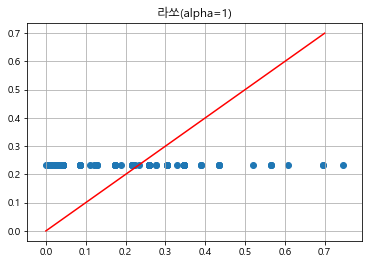

<Figure size 504x288 with 0 Axes>

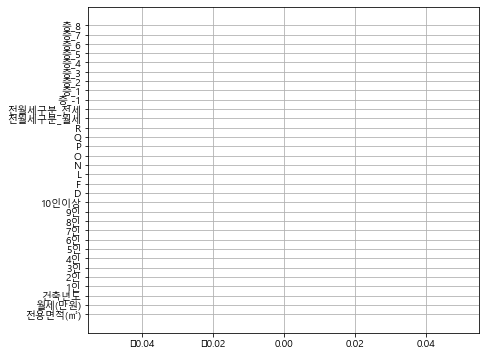

X_train,y_train Accuracy: 0.0%
X_test,y_test Accuracy: -8.23%
lasso alpha0.1 y_test,pred Mse 0.15467732974033035
lasso alpha0.1 y_test,pred SQRT Mse 0.18238013598215969


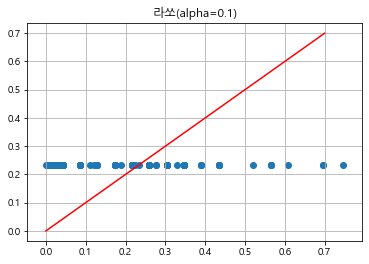

<Figure size 504x288 with 0 Axes>

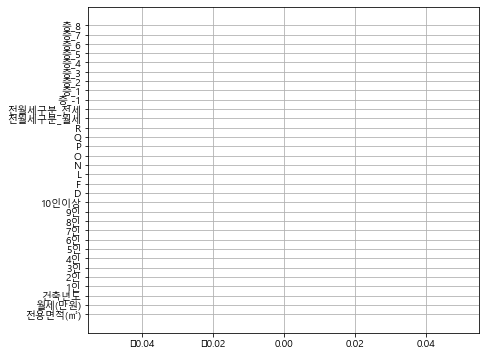

X_train,y_train Accuracy: 60.51%
X_test,y_test Accuracy: 62.64%
lasso alpha0.01 y_test,pred Mse 0.08405825173539208
lasso alpha0.01 y_test,pred SQRT Mse 0.1071517388460807


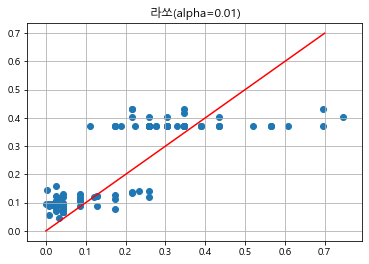

<Figure size 504x288 with 0 Axes>

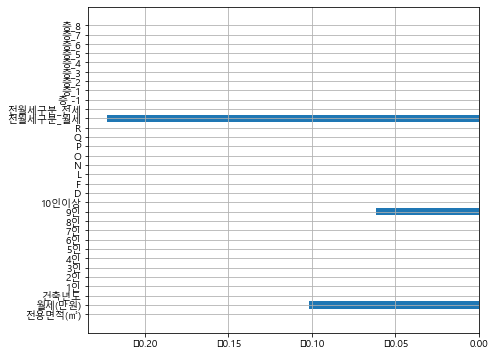

X_train,y_train Accuracy: 74.74%
X_test,y_test Accuracy: 60.77%
lasso alpha0.001 y_test,pred Mse 0.07719118092952089
lasso alpha0.001 y_test,pred SQRT Mse 0.10979456029394626


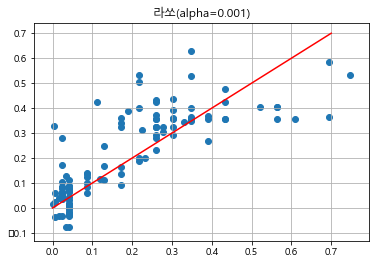

<Figure size 504x288 with 0 Axes>

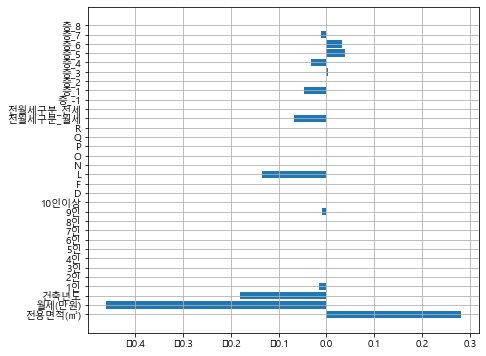

X_train,y_train Accuracy: 81.57%
X_test,y_test Accuracy: 66.2%
lasso alpha0.0001 y_test,pred Mse 0.07096137651578038
lasso alpha0.0001 y_test,pred SQRT Mse 0.10191298536588231


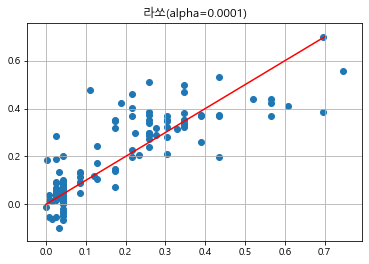

<Figure size 504x288 with 0 Axes>

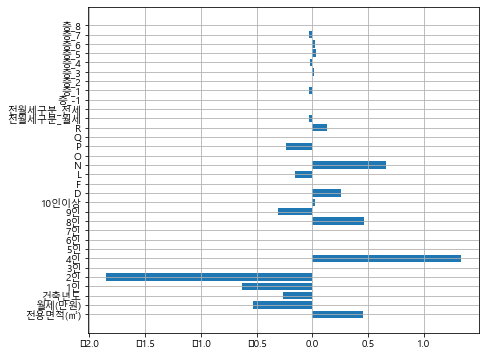

In [96]:
for alpha in alphas :
    단독다가구 = pd.read_csv('./data/8.세종시_연립다세대(전월세)_실거래가.csv', encoding='cp949')
    라쏘4("라쏘(alpha={})".format(alpha),alpha,전처리3(단독다가구))

In [97]:
def 전처리4(부동산): # 파일 5번만
    
    #상권대분류 전처리
    상권_대분류 = 상권.groupby(['행정동명','상권업종대분류코드']).count()
    상권_대분류 = 상권_대분류[['lon']]
    상권_대분류.rename(columns = {"lon":"count"},inplace=True)
    상권_대분류= 상권_대분류.reset_index()
    상권대분류_피벗 = pd.pivot_table(상권_대분류, index=['행정동명'], columns=['상권업종대분류코드'])
    상권대분류_피벗 = 상권대분류_피벗['count']
    상권대분류_피벗.columns.name = None 
    #아파트 전처리
    부동산 = 부동산[['시군구','계약면적(㎡)','도로조건','전월세구분','보증금(만원)','월세(만원)','건축년도']]
    부동산['읍면동']= 부동산['시군구'].str.split(" ").str[1]
    #세대수 전처리
    세대수['읍면동'] = 세대수['읍면동'].str.replace(' ', "")
    try :
        del 세대수['계']
    except :
        pass
    #아프트_세대수 변수 생성
    부동산_세대수 = 부동산.merge(세대수, on='읍면동', how='left')
    부동산_세대수 = 부동산_세대수.merge(상권대분류_피벗, left_on = '읍면동',  right_on= '행정동명', how='left')
    del 부동산_세대수['읍면동']
    부동산_세대수 = 부동산_세대수.fillna(0)
    부동산_세대수['건축년도'] = 2021- 부동산_세대수['건축년도']
    부동산_세대수 = pd.get_dummies(부동산_세대수, columns=['전월세구분','도로조건'])
    
    return 부동산_세대수


In [98]:
def 라쏘5(name,alpha,부동산):  
    try:
        부동산['거래금액(만원)'] = 부동산['거래금액(만원)'].str.replace(",","")
        부동산['거래금액(만원)'].astype('int64')
    
    except:
        pass
    
    x_num= 부동산[[ '계약면적(㎡)', '보증금(만원)', '월세(만원)', '건축년도', '1인', '2인', '3인', '4인',
       '5인', '6인', '7인', '8인', '9인', '10인이상', 'D', 'F', 'L', 'N', 'O', 'P',
       'Q', 'R', '전월세구분_월세', '전월세구분_전세', '도로조건_-', '도로조건_12m미만', '도로조건_25m미만',
       '도로조건_25m이상', '도로조건_8m미만']]
    
    

    scaler = MinMaxScaler()
    scaler.fit(x_num)
    X_scaled = scaler.transform(x_num)
    X_scaled = pd.DataFrame(X_scaled, index=x_num.index, columns=x_num.columns)
    #X = pd.concat([X_scaled, x_cat], axis=1)
    y =X_scaled[['보증금(만원)']]
    X= X_scaled.drop('보증금(만원)',axis=1)
   

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    lasso = Lasso(alpha=alpha,random_state=42)
    lasso.fit(X_train, y_train)
    print("X_train,y_train Accuracy: {}%".format(round(lasso.score(X_train, y_train)*100, 2)))
    print("X_test,y_test Accuracy: {}%".format(round(lasso.score(X_test, y_test)*100, 2)))
    pred = lasso.predict(X_test)
    print(f"lasso alpha{alpha} y_test,pred Mse",mean_absolute_error(y_test, pred))
    print(f"lasso alpha{alpha} y_test,pred SQRT Mse",np.sqrt(mean_squared_error(y_test, pred)))
    plt.title(name)
    plt.grid(True)
    plt.scatter(x=y_test, y=pred)
    plt.plot([0, 0.7], [0, 0.7], 'r-')
    plt.figure(figsize=(7, 4))
    
    
    plt.show()
    plt.figure(figsize=(7, 6))
    plt.barh(X_train.columns, lasso.coef_)
    plt.grid(True)
    plt.show()



X_train,y_train Accuracy: 0.0%
X_test,y_test Accuracy: -0.25%
lasso alpha100 y_test,pred Mse 0.038805273257701146
lasso alpha100 y_test,pred SQRT Mse 0.06930712652749234


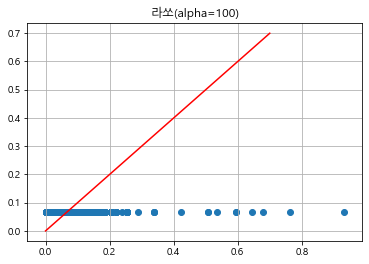

<Figure size 504x288 with 0 Axes>

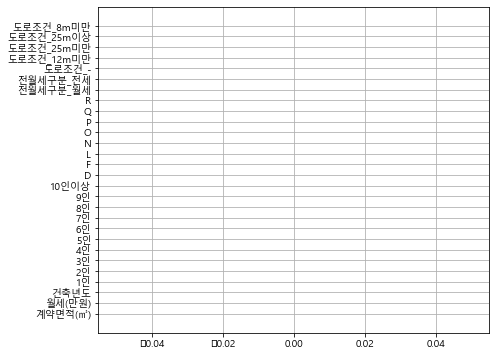

X_train,y_train Accuracy: 0.0%
X_test,y_test Accuracy: -0.25%
lasso alpha10 y_test,pred Mse 0.038805273257701146
lasso alpha10 y_test,pred SQRT Mse 0.06930712652749234


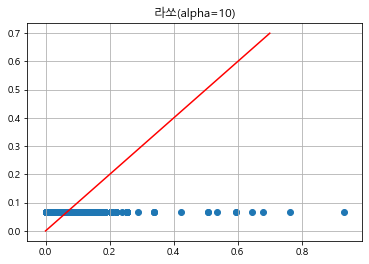

<Figure size 504x288 with 0 Axes>

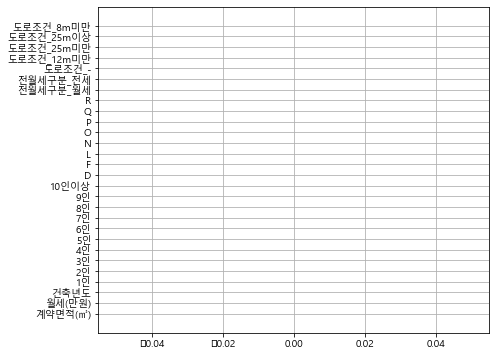

X_train,y_train Accuracy: 0.0%
X_test,y_test Accuracy: -0.25%
lasso alpha1 y_test,pred Mse 0.038805273257701146
lasso alpha1 y_test,pred SQRT Mse 0.06930712652749234


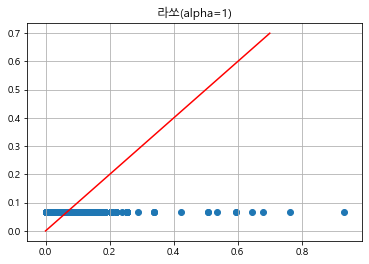

<Figure size 504x288 with 0 Axes>

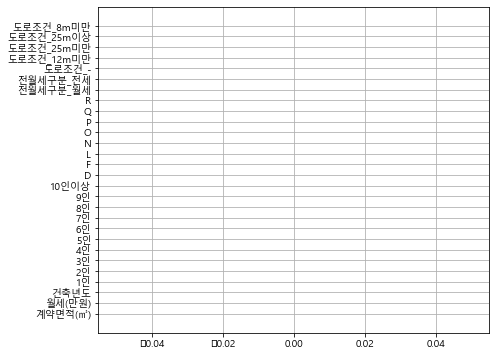

X_train,y_train Accuracy: 0.0%
X_test,y_test Accuracy: -0.25%
lasso alpha0.1 y_test,pred Mse 0.038805273257701146
lasso alpha0.1 y_test,pred SQRT Mse 0.06930712652749234


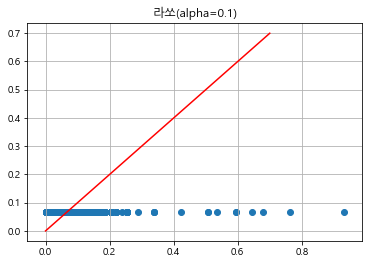

<Figure size 504x288 with 0 Axes>

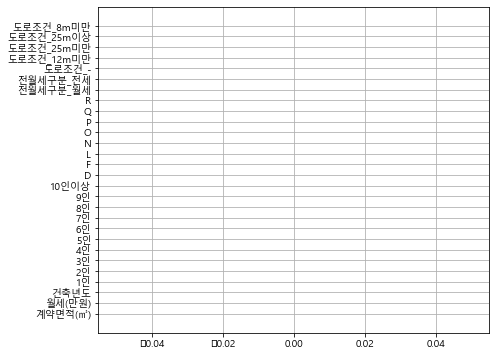

X_train,y_train Accuracy: 13.1%
X_test,y_test Accuracy: 9.89%
lasso alpha0.01 y_test,pred Mse 0.03500035008094773
lasso alpha0.01 y_test,pred SQRT Mse 0.06570791364733418


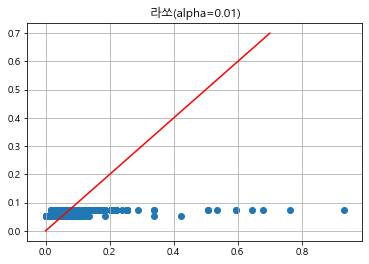

<Figure size 504x288 with 0 Axes>

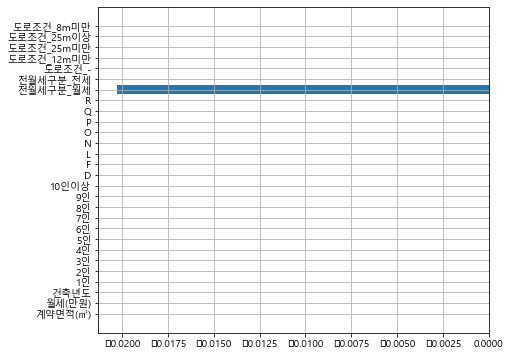

X_train,y_train Accuracy: 51.83%
X_test,y_test Accuracy: 47.16%
lasso alpha0.001 y_test,pred Mse 0.023873462380675378
lasso alpha0.001 y_test,pred SQRT Mse 0.0503162219781248


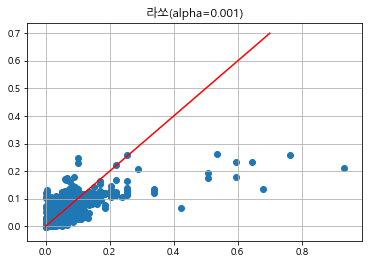

<Figure size 504x288 with 0 Axes>

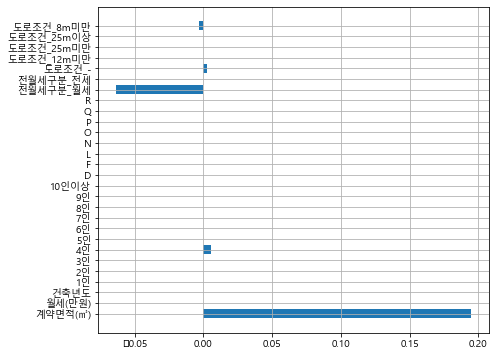

X_train,y_train Accuracy: 65.94%
X_test,y_test Accuracy: 69.44%
lasso alpha0.0001 y_test,pred Mse 0.021143286960035177
lasso alpha0.0001 y_test,pred SQRT Mse 0.03826746461685477


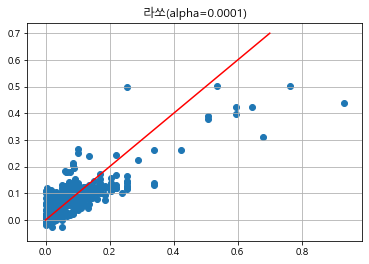

<Figure size 504x288 with 0 Axes>

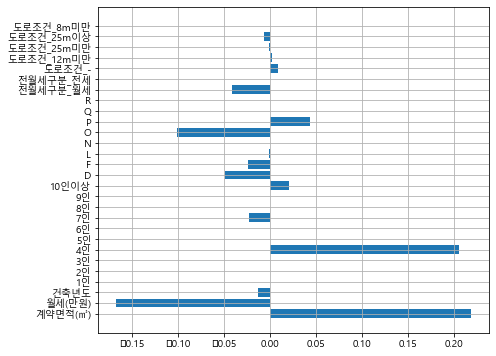

In [99]:
for alpha in alphas:    
    단독다가구 = pd.read_csv('./data/9.세종시_단독다가구(전월세)_실거래가.csv', encoding='cp949')
    라쏘5("라쏘(alpha={})".format(alpha),alpha,전처리4(단독다가구))

In [100]:
def 라쏘6(name,alpha,부동산):  
    try:
        부동산['거래금액(만원)'] = 부동산['거래금액(만원)'].str.replace(",","")
        부동산['거래금액(만원)'].astype('int64')
    
    except:
        pass
    
    x_num= 부동산[[ '전용면적(㎡)', '보증금(만원)', '월세(만원)', '건축년도', '1인', '2인', '3인', '4인',
       '5인', '6인', '7인', '8인', '9인', '10인이상', 'D', 'F', 'L', 'N', 'O', 'P',
       'Q', 'R', '전월세구분_월세', '전월세구분_전세', '층_2', '층_3', '층_4', '층_5', '층_6',
       '층_7', '층_8', '층_9', '층_10', '층_11', '층_12', '층_13', '층_14', '층_15',
       '층_16', '층_17', '층_18', '층_19', '층_20']]
    
    

    scaler = MinMaxScaler()
    scaler.fit(x_num)
    X_scaled = scaler.transform(x_num)
    X_scaled = pd.DataFrame(X_scaled, index=x_num.index, columns=x_num.columns)
    #X = pd.concat([X_scaled, x_cat], axis=1)
    y =X_scaled[['보증금(만원)']]
    X= X_scaled.drop('보증금(만원)',axis=1)
   

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    lasso = Lasso(alpha=alpha,random_state=42)
    lasso.fit(X_train, y_train)
    print("X_train,y_train Accuracy: {}%".format(round(lasso.score(X_train, y_train)*100, 2)))
    print("X_test,y_test Accuracy: {}%".format(round(lasso.score(X_test, y_test)*100, 2)))
    pred = lasso.predict(X_test)
    print(f"lasso alpha{alpha} y_test,pred Mse",mean_absolute_error(y_test, pred))
    print(f"lasso alpha{alpha} y_test,pred SQRT Mse",np.sqrt(mean_squared_error(y_test, pred)))
    plt.title(name)
    plt.grid(True)
    plt.scatter(x=y_test, y=pred)
    plt.plot([0, 0.7], [0, 0.7], 'r-')
    plt.figure(figsize=(7, 4))
    
    
    plt.show()
    plt.figure(figsize=(7, 6))
    plt.barh(X_train.columns, lasso.coef_)
    plt.grid(True)
    plt.show()



X_train,y_train Accuracy: 0.0%
X_test,y_test Accuracy: -0.11%
lasso alpha100 y_test,pred Mse 0.23662814603969168
lasso alpha100 y_test,pred SQRT Mse 0.24719915916722304


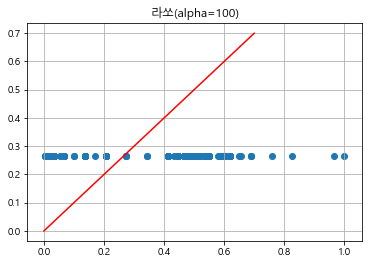

<Figure size 504x288 with 0 Axes>

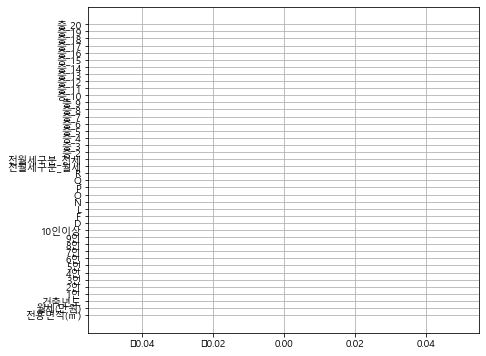

X_train,y_train Accuracy: 0.0%
X_test,y_test Accuracy: -0.11%
lasso alpha10 y_test,pred Mse 0.23662814603969168
lasso alpha10 y_test,pred SQRT Mse 0.24719915916722304


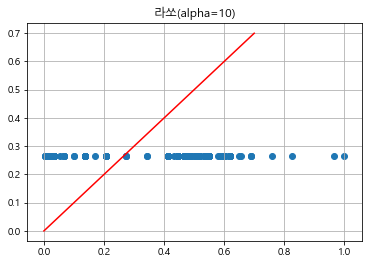

<Figure size 504x288 with 0 Axes>

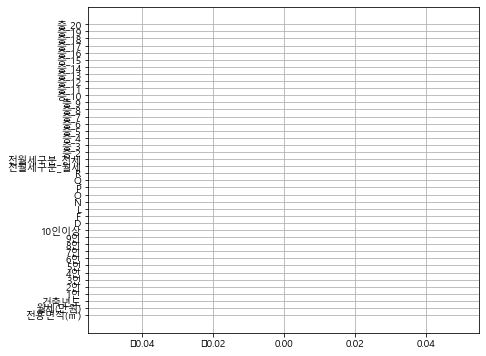

X_train,y_train Accuracy: 0.0%
X_test,y_test Accuracy: -0.11%
lasso alpha1 y_test,pred Mse 0.23662814603969168
lasso alpha1 y_test,pred SQRT Mse 0.24719915916722304


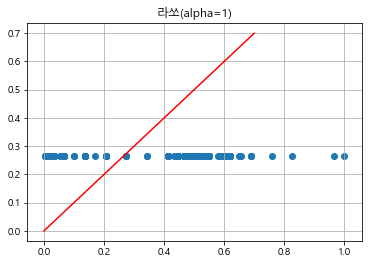

<Figure size 504x288 with 0 Axes>

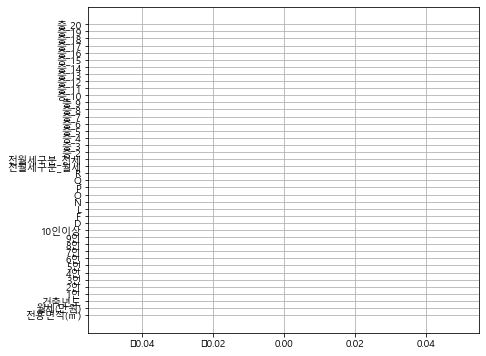

X_train,y_train Accuracy: 27.18%
X_test,y_test Accuracy: 27.07%
lasso alpha0.1 y_test,pred Mse 0.19981562637996994
lasso alpha0.1 y_test,pred SQRT Mse 0.21098386714204925


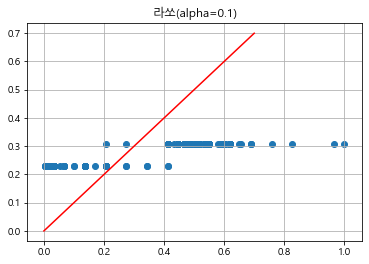

<Figure size 504x288 with 0 Axes>

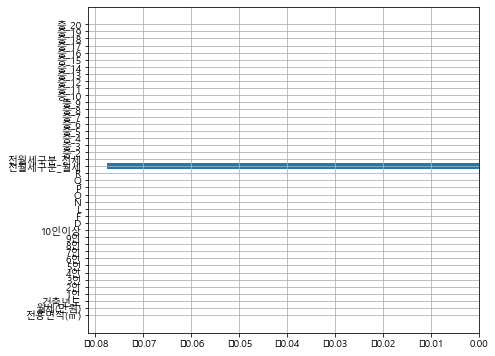

X_train,y_train Accuracy: 90.94%
X_test,y_test Accuracy: 89.58%
lasso alpha0.01 y_test,pred Mse 0.05496110646590573
lasso alpha0.01 y_test,pred SQRT Mse 0.0797663235492255


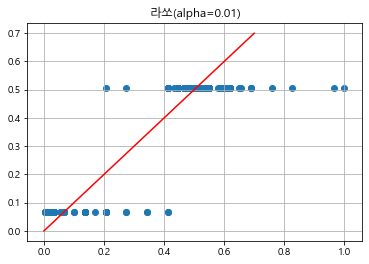

<Figure size 504x288 with 0 Axes>

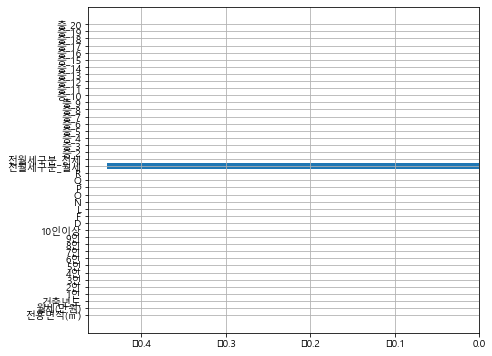

X_train,y_train Accuracy: 94.17%
X_test,y_test Accuracy: 93.11%
lasso alpha0.001 y_test,pred Mse 0.039180075399792395
lasso alpha0.001 y_test,pred SQRT Mse 0.06487116243057316


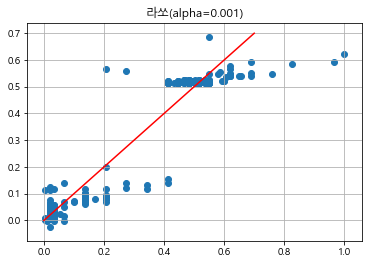

<Figure size 504x288 with 0 Axes>

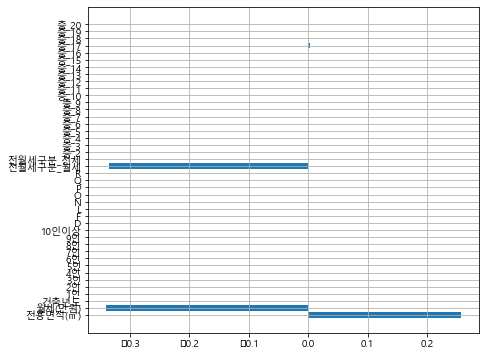

X_train,y_train Accuracy: 95.27%
X_test,y_test Accuracy: 94.51%
lasso alpha0.0001 y_test,pred Mse 0.03641299967416649
lasso alpha0.0001 y_test,pred SQRT Mse 0.0578717170224404


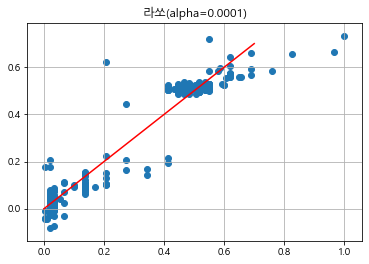

<Figure size 504x288 with 0 Axes>

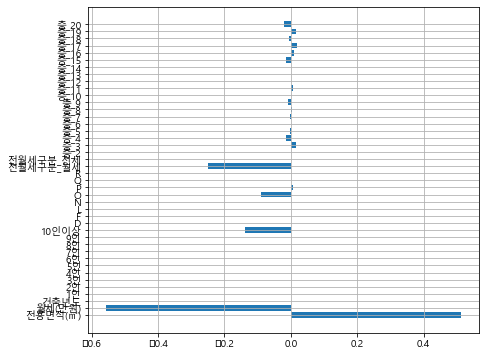

In [101]:
for alpha in alphas :
    단독다가구 = pd.read_csv('./data/10.세종시_오피스텔(전월세)_실거래가.csv', encoding='cp949')
    라쏘6("라쏘(alpha={})".format(alpha),alpha,전처리3(단독다가구))
